C:\Users\User\AppData\Local\Temp\ipykernel_21744\510561547.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polys.append(gdf.unary_union.convex_hull)
C:\Users\User\AppData\Local\Temp\ipykernel_21744\510561547.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polys.append(gdf.unary_union.convex_hull)
C:\Users\User\AppData\Local\Temp\ipykernel_21744\510561547.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polys.append(gdf.unary_union.convex_hull)
C:\Users\User\AppData\Local\Temp\ipykernel_21744\510561547.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  isochrone_polys.append(gdf.unary_union.convex_hull)


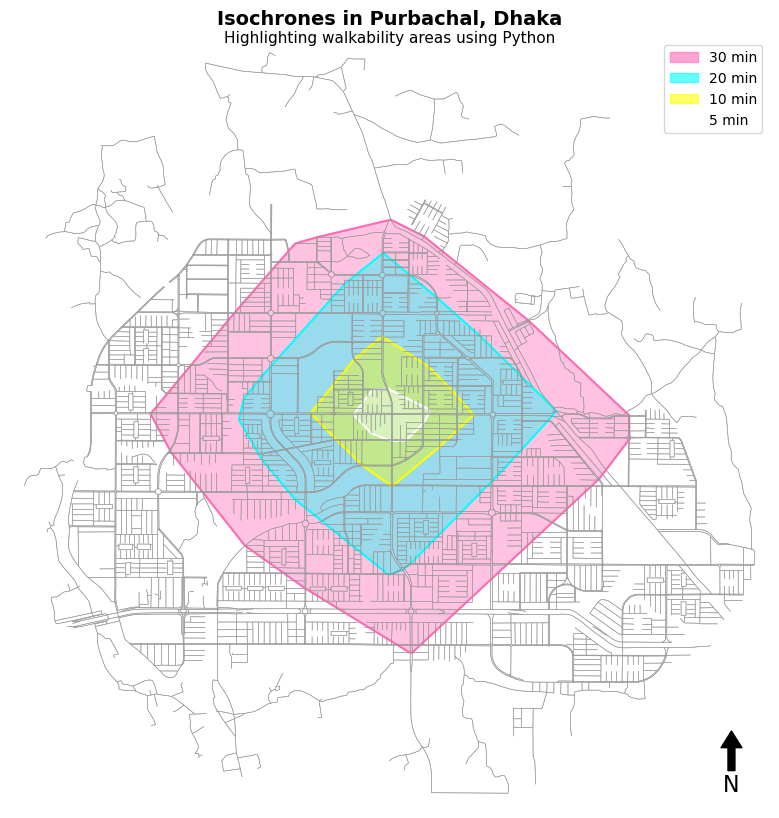

In [42]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Coordinates of central Purbachal (adjust if needed)
lat, lon = 23.8552, 90.5051
center_point = Point(lon, lat)

# Project center point to UTM (meters) for accurate buffering
projected_point, crs = ox.projection.project_geometry(center_point)
buffer_distance = 4000  # meters
circular_buffer = projected_point.buffer(buffer_distance)

# Wrap in GeoDataFrame and set CRS
buffer_gdf = gpd.GeoDataFrame(geometry=[circular_buffer], crs=crs)

# Reproject back to WGS84 (EPSG:4326)
buffer_geom = buffer_gdf.to_crs("EPSG:4326").geometry.iloc[0]

# Step 1: Get walkable network within buffer
G = ox.graph_from_polygon(buffer_geom, network_type='walk')

# Step 2: Add travel time attribute to edges
walking_speed = 1.39  # meters/second
for u, v, data in G.edges(data=True):
    data['travel_time'] = data['length'] / walking_speed

# Step 3: Define center node
center_node = ox.distance.nearest_nodes(G, lon, lat)

# Step 4: Generate isochrones
isochrone_times = [5, 10, 20, 30]  # in minutes
isochrone_polys = []

for time in isochrone_times:
    subgraph = nx.ego_graph(G, center_node, radius=time * 60, distance="travel_time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    
    if node_points:
        gdf = gpd.GeoSeries(node_points)
        isochrone_polys.append(gdf.unary_union.convex_hull)

# Step 5: Plotting
colors = ['hotpink', 'cyan', 'yellow', 'white']
#colors = ['#FFB6C1', '#87CEEB', '#AFEEEE', '#8470FF']  # Pink, Cyan, Turquoise, Slate Blue

fig, ax = plt.subplots(figsize=(10, 10))

for idx, (poly, time) in enumerate(reversed(list(zip(isochrone_polys, isochrone_times)))):
    gpd.GeoSeries([poly]).plot(ax=ax, color=colors[idx], alpha=0.4)
    gpd.GeoSeries([poly]).plot(ax=ax, color='none', edgecolor=colors[idx], linewidth=1.5)

# Create custom legend
handles = [mpatches.Patch(color=colors[i], label=f"{t} min", alpha=0.6)
           for i, t in enumerate(reversed(isochrone_times))]
plt.legend(handles=handles)

# Plot network graph
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.4, show=False, close=False)

# Add North arrow
x, y, arrow_length = 0.95, 0.1, 0.07  # position and length relative to axes coordinates
ax.annotate('N',
            xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center',
            fontsize=16,
            xycoords=ax.transAxes)

# Final touches
ax.set_title("Isochrones in Purbachal, Dhaka", 
             fontsize=14, 
             fontweight='bold', 
             pad=10)  # Increase pad to move title down
# Subtitle just below the main title
ax.text(0.5, 1.01, "Highlighting walkability areas using Python", transform=ax.transAxes,
        fontsize=11, ha='center', va='top')

plt.savefig("Isochrones in Purbachal.jpg", dpi=300, format="jpeg", bbox_inches="tight")
plt.show()
